In [1]:
import os, sys
os.environ["MKL_NUM_THREADS"]='6' 
os.environ["NUMEXPR_NUM_THREADS"]='6'
os.environ["OMP_NUM_THREADS"]='6'

import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
import autograd.numpy as np
import torch
from copy import deepcopy
from tqdm import trange, tqdm_notebook
from Datasets import LatentDynamics, Observations, SSM
from Inferences import SMC
from DDC import Features, DDC, DDCSSM, Regressors
from datetime import datetime
from scipy.stats import norm
from collections import OrderedDict
from settings import CTX

if sys.version_info[0] > 2:
    
    from importlib import reload

%matplotlib inline

## set up the internal model

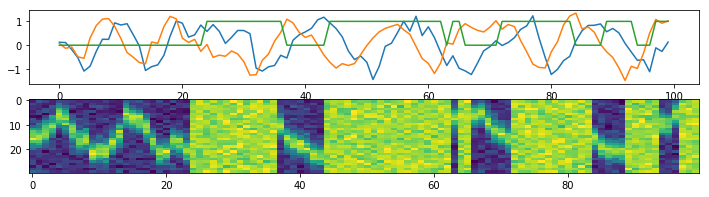

In [2]:
D = 3
Dx = 30
init_noise_std = 0.1

seed=1

nl = lambda x: torch.tanh(x)
dnl= lambda x: 1-torch.tanh(x)**2

np.random.seed(seed)
torch.manual_seed(seed)

ang = np.pi/8

true_Z = LatentDynamics.RotationLatent(ang, 1.0, [0.3]*2)
true_Z = LatentDynamics.MaskingLatent(true_Z, 0.1,0.1)
true_X = Observations.BumpObservation(Dx, 2., bar_width=0.1, noise_std=0.1)
true_X = Observations.OccludedObservation(true_X, 0.1)
true_model = SSM.StateSpaceModel(true_Z, true_X, init_noise_std)

T =100
nchain = 10
data = true_model.sample(T,10)

fig,axes = plt.subplots(2,1, figsize=(12,3))
ax = axes[0]
ax.plot(data["zt"][:,0,:].cpu().numpy())
ax = axes[1]
im = ax.imshow(data["xt"].cpu().numpy()[:,0,:].T, aspect="auto", vmin=-0.2, vmax=1.2)

The latent trajectory is around a circle but occasionally passes through the center

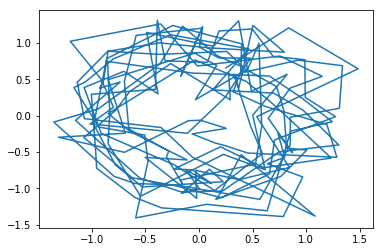

In [3]:
zs = true_model.sample(200,1)["zt"].cpu().numpy()
plt.plot(zs[:,0,0], zs[:,0,1])

Set up the feature functions

In [5]:
M = 100
Mx= 150
adaptive=False
init_std_z = 1.0
init_std_x = 1.0

z_nl = lambda x: torch.tanh(x)
samples = true_model.sample(T,100)
zt_samples = samples["zt"].view(-1, D)
zt_mean, zt_std = zt_samples.mean(0).cpu().numpy(), zt_samples.std(0).cpu().numpy()

map_z = Features.ContinuousFeature(M,  D,  init_std_z, [zt_mean-2*zt_std, zt_mean+2*zt_std], 
                                   adaptive=adaptive, nl = z_nl)

map_x = Features.ContinuousFeature(Mx, Dx, init_std_x, [-1, 2], adaptive=adaptive)

fs ={ 
      "xt": map_x,
      "zt":   deepcopy(map_z),
      "zt-1": deepcopy(map_z),
}

fs_pre ={ "xt":   deepcopy(map_x),
      "zt":   deepcopy(map_z),
      "zt-1": deepcopy(map_z),
}

Check the histogram of the feature functions. We don't want the values to be too concentrated around 0 or at +/- 1.

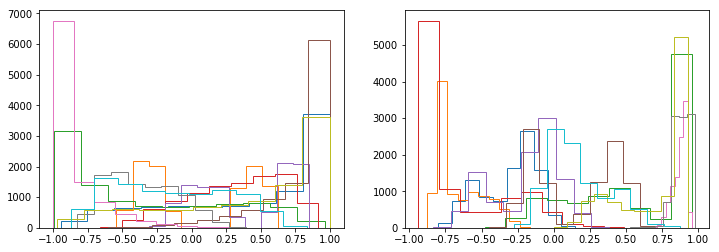

In [6]:
data = true_model.sample(100,100)

fz = fs["zt"](data["zt"]).cpu().detach()
fx = fs["xt"](data["xt"]).cpu().detach()

fig, axes= plt.subplots(1,2,figsize=(12,4))
for i in range(min(M,10)):
    axes[0].hist(fz.reshape(-1, M)[:,i], alpha=1.0,histtype='step');
for i in range(min(Mx,10)):
    axes[1].hist(fx.reshape(-1, Mx)[:,i], alpha=1.0,histtype='step');

Set up the DDC regressor for temporal case (distribution regression)

In [7]:
# step_reg = Regressors.LinearRegressorStep(fs,lr=0.01,momentum=0.0, lam=1e-3, niter=1)

reg = Regressors.LinearRegressor(fs,lam=1e-3, tensor_op="c", lr=0.00)
torch.manual_seed(1)
# opt = Optimizers.SGDOptimizer(lr=0.001, momentum=0.9, decay=0.0)
ddc=DDCSSM.DecayDistributionRegression([1]*5,(true_model), (reg), 
                                  opt=None, 
                                  s_type="sample", 
                                  g_type="exp", 
                                  smoothing=False, 
                                  nsleep=20000, 
                                  nwake=100,
                                  plastic=[True, True], 
                                  factorise=False,
                                  stationary=False,
                                  nretain = 100,
                                  look_back=10,
                                      )

Manually set up the masks for testing

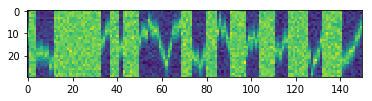

In [8]:
T_train=50
T = T_train+100
nwake = ddc.nwake
z0 = true_model.sample_initial(nwake)
d = true_model.step(z0,0)
test_data = true_model.sample(T, ddc.nwake)

gap = 6
test_masks = torch.tensor([0]*T_train+[0]*2+
                          [1]*5+[0]*gap+
                          [1]*5+[0]*gap+
                          [1]*7+[0]*gap+
                          [1]*7+[0]*gap+
                          [1]*9+[0]*gap+
                          [1]*9+[0]*gap+
                          [0]*3, **CTX)
test_data["zt"][T_train:,...,-1] = test_masks[-(T-T_train):][:,None]
test_data["xt"] = true_model.observation.sample(test_data["zt"])
plt.imshow(test_data["xt"][:,2,:].cpu().numpy().T)

Train the filter for T_train steps, and then test for T-T_train steps.

In [9]:
d = test_data["xt"]
ddc.initialise(d[0])

for t in tqdm_notebook(range(1,T+1)):
    
    ddc.reg.R2s={}
    if t <=T_train:
        ddc.sleep_train_test()
    else:
        ddc.sleep_test()
    if t != T:
        ddc.propagate(d[t])

ddc.finalise()

In [10]:
ddc.wake_history["Ezt-0_x1:t"]=ddc.wake_history["Ezt_x1:t"]

In [11]:
nlag=10
errors=[]
test_data_z = test_data["zt"].cpu().numpy()

In [12]:
histograms = []
decode_lags=[0,2,5,8]

bins = np.linspace(-2,2,20)
for li, lag in enumerate(tqdm_notebook(decode_lags)):
    histogram = []
    for t in range(T-T_train-lag):
        grid = ddc.sleep_history["zt"][t,:,0]
        fv   = ddc.sleep_history["fzzt"][t+lag,:]
        bin_fv = ((bins[1:,None] > grid[None]) & (bins[:-1,None] < grid[None])).astype("float").T
        W = np.linalg.solve(fv.T.dot(fv)+np.eye(fv.shape[1])*1e-5, fv.T.dot(bin_fv))
        h = ddc.wake_history["mzzt_x1:t"][t+lag,:] @ W
        h= h.clip(0,1)
        h/=h.sum(-1,keepdims=True)
        histogram += h,
    histogram = np.concatenate([np.array(histogram), np.full((lag, nwake,h.shape[-1]),np.nan)], 0)
    histograms += histogram,
histograms= np.asarray(histograms)

In [13]:
ngrid = 20
zgrid = bins

def samples_to_hist(samples, weights, edges):
    
    # length, nchain and sample size
    T, C, N = weights.shape
    E = len(edges)-1

    posts = np.zeros((T, C, E))
    for ci in range(C):
        for t in range(T):
            posts[t,ci] = np.histogram(samples[t,ci,:,0],
                                          weights=weights[t,ci,:],bins=edges, 
                                          normed=True)[0]
    posts /= posts.sum(-1, keepdims=True)
    return posts


samples, weights = SMC.filtering_bootstrap(true_model, test_data["xt"][:,:,:], 
                                           nsample=1000, bar=True)
samples = samples.cpu().numpy()
weights = weights.cpu().numpy()
pf_pm = np.sum(weights[...,None] * samples, -2)
pf_posts = samples_to_hist(samples, weights, zgrid)
pf_pm = pf_pm[T_train:]
pf_posts = pf_posts[T_train:]

100%|█████████████████████████████████████████████████████████████| 150/150 [00:15<00:00,  9.58it/s]
/nfs/nhome/live/kevinli/anaconda/envs/ddc_ssm_3/lib/python3.6/site-packages/autograd/tracer.py:48: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  return f_raw(*args, **kwargs)


In [14]:
test_x = test_data["xt"].cpu().numpy()
test_z = test_data["zt"].cpu().numpy()

samples = samples
weights = weights
T = T
T_train=T_train
#histograms=histograms
ddc_keys = []
ddc_means =[]
for i in range(0, 11):
    ddc_keys += "Ezt-%d_x1:t"%i,

    ddc_means += np.concatenate([ddc.wake_history.data["Ezt-%d_x1:t"%i][i:],
                                np.full((i,nwake,D), np.nan)], 0),

In [15]:
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Text(0, 0.5, 'q(z)')

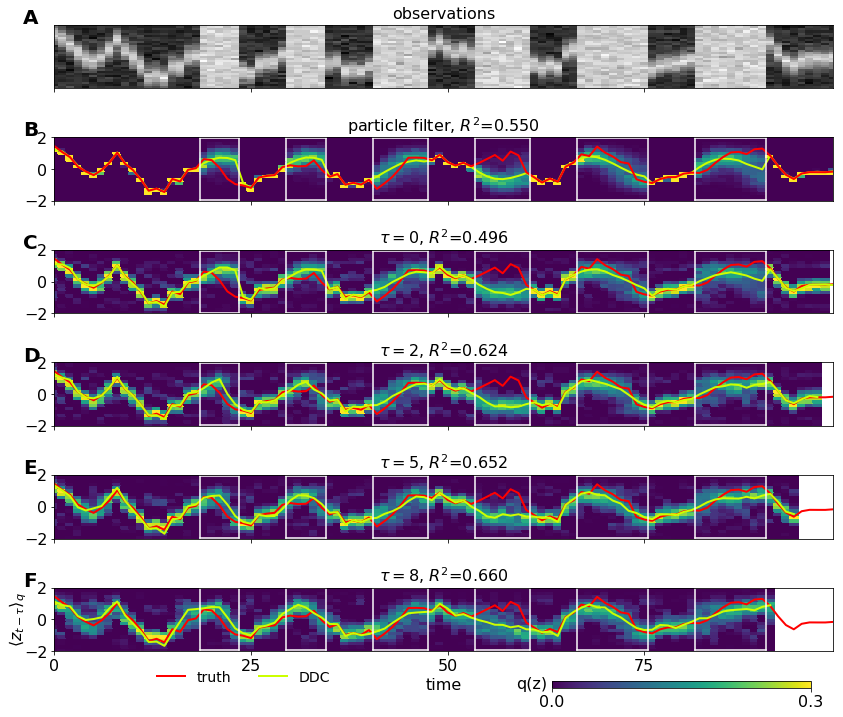

In [16]:
batch_idx=49
bins = np.linspace(-2,2,20)
decode_lags=[0,2,5,8]
ddc_color=[0.8,1,0.]
true_color=[1,0,0]
letter_ascii = 65

def plot_mask_boxes(ax, z):
    on_times = np.where(np.diff(z)==1)[0]
    off_times = np.where(np.diff(z)==-1)[0]

    ax.plot(np.stack([on_times,off_times])+0.5, [1.95,1.95], "w")
    ax.plot(np.stack([on_times,off_times])+0.5, [-1.95,-1.95], "w")
    
    
    ax.plot(np.stack([on_times,on_times])+0.5, [-1.95,1.95], "w")
    ax.plot(np.stack([off_times,off_times])+0.5, [-1.95,1.95], "w")
    
def add_letter(ax,letter_ascii):
    ax.text(-0.04,1.02,chr(letter_ascii), transform=ax.transAxes, 
            fontsize=20, fontweight="heavy")
    letter_ascii+=1

true_x = test_x[T_train:,batch_idx]
true_z = test_z[T_train:,batch_idx,0]
fig, axes = plt.subplots(len(decode_lags)+2,1,figsize=(12,10), sharex=True, sharey=False)
ax =axes[0]
add_letter(ax, letter_ascii)
letter_ascii += 1


ax.imshow(true_x.T, aspect="auto", origin="lower", cmap="gray")
ax.set_ylim(-0.5,Dx-0.5)
ax.set_yticks([])
ax.set_title("observations")

ax = axes[1]
ax.pcolormesh(np.arange(T-T_train+1)-0.5, bins,pf_posts[:,batch_idx,:].T, vmin=0, vmax=0.3, edgecolor="face")
ax.plot(np.arange(T-T_train), pf_pm[:,batch_idx,0], color=ddc_color, lw=2, label="exact")
ax.plot(true_z, color=true_color, lw=2, label="truth")
r2 = 1-np.mean((true_z[:] - pf_pm[:,batch_idx,0])**2)/true_z.var()
ax.set_title(r"particle filter, $R^2$=%.3f"%(r2))
plot_mask_boxes(ax,test_z[T_train:,batch_idx,2])
ax.set_ylim(-2,2)
add_letter(ax,letter_ascii)
letter_ascii += 1

for li, lag in enumerate(decode_lags):
    ax = axes[2+li]

    if lag == 0:
        true_z = test_z[T_train:,batch_idx,0]
    else:
        true_z = test_z[T_train:,batch_idx,0]
    ax.plot(true_z, color=true_color, lw=2, label="truth")
    ddc_z  = ddc_means[lag][:,batch_idx,0]
    ax.plot(ddc_z, color=ddc_color, lw=2, label="DDC")
    r2 = 1-np.nanmean((true_z[:] - ddc_z[:])**2)/true_z[:].var()
    ax.set_title(r"$\tau=%d$, $R^2$=%.3f"%(lag, r2))
    im = ax.pcolormesh(np.arange(T+1-T_train-1)-0.5, bins, histograms[li][:-1,batch_idx,:].T, 
                       vmin=0,vmax=0.3, edgecolor="face") 
#     im = ax.pcolormesh(np.arange(T-T_train+1).T-0.5, np.linspace(-2,2,21), 
#                        opt_histogram[li].sum((-1,-2)).T, 
#                        vmin=0,vmax=0.5, edgecolor="face") 
    plot_mask_boxes(ax,test_z[T_train:,batch_idx,2])

    ax.set_xlim(0,T-1-T_train)
    ax.set_xticks(np.arange(0,T-T_train,25))
    ax.set_xticklabels(np.arange(0,T-T_train,25))
    add_letter(ax,letter_ascii)
    letter_ascii += 1

ax.set_ylim(-2,2)
axes[-1].set_xlabel("time")
axes[-1].set_ylabel(r"$\langle z_{t-\tau}\rangle_q$", labelpad=-5)
fig.tight_layout()
axes[-1].legend(loc="upper right", bbox_to_anchor=(0.37,-0.1), frameon=False, ncol=2)

cbaxes = fig.add_axes([0.65, 0.03, 0.3, 0.01]) 
cb = plt.colorbar(im, cax = cbaxes,orientation="horizontal", ticks=[0,0.3])  
cbaxes.set_ylabel("q(z)", rotation=0, va="center",labelpad=20)
#$fig.savefig("figs/sines_%d.pdf"%batch_idx, pad_inches=0, bbox_inches="tight")

In [17]:
from Utils import decode
from itertools import product
f_W = ddc.reg.fs["zt"].W.cpu().numpy()
f_b = ddc.reg.fs["zt"].b.cpu().numpy()
bins = np.linspace(-2,2,20)
nbins=len(bins)
cross_bins = np.array(list(product(bins, bins, [0,1])))

opt_histogram = np.full((len(decode_lags),100,nbins,nbins,2), np.nan)


batch_idx = 49
for li, lag in enumerate(tqdm_notebook(decode_lags)):
    for t in tqdm_notebook(range(T-T_train-lag)):

        fv   = ddc.sleep_history["fzzt"][t+lag]
        y = np.tanh(ddc.sleep_history["zt"][t] @ f_W + f_b)
        W = np.linalg.solve( fv.T @ fv+np.eye(fv.shape[1])*1e-3, fv.T @ y)
        
        marginal_m = ddc.wake_history["mzzt_x1:t"][t+lag,batch_idx] @ W

        def phi_fun(x):
            return np.tanh(x[None]@f_W + f_b)[0]

        h = decode(marginal_m, phi_fun, cross_bins)
        opt_histogram[li, t] = h.reshape(nbins,nbins,2)

Text(0, 0.5, 'q(z)')

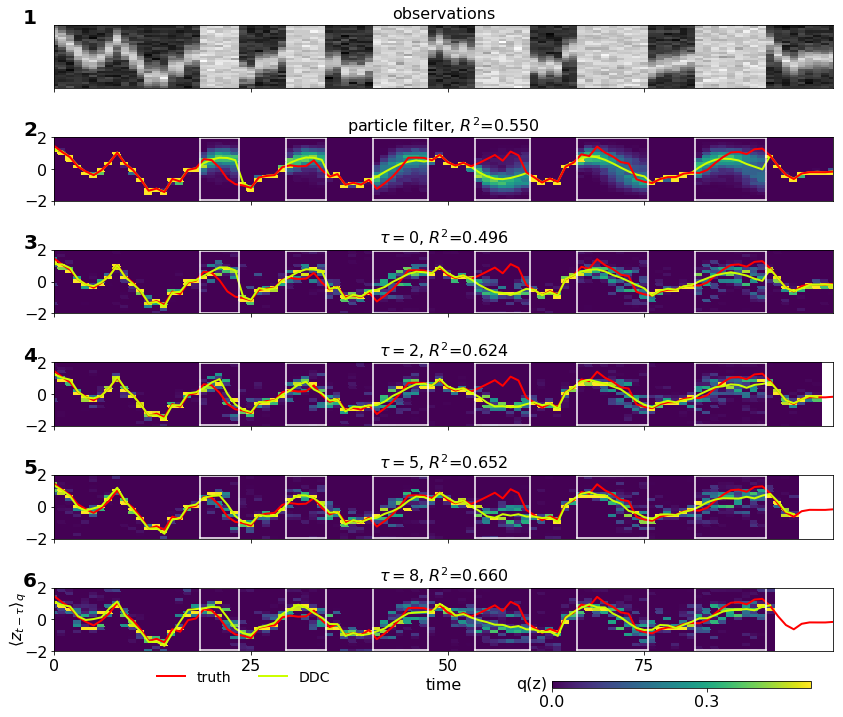

In [18]:
batch_idx=49
bins = np.linspace(-2,2,20)
decode_lags=[0,2,5,8]
ddc_color=[0.8,1,0.]
true_color=[1,0,0]
letter_ascii = 49

def plot_mask_boxes(ax, z):
    on_times = np.where(np.diff(z)==1)[0]
    off_times = np.where(np.diff(z)==-1)[0]

    ax.plot(np.stack([on_times,off_times])+0.5, [1.95,1.95], "w")
    ax.plot(np.stack([on_times,off_times])+0.5, [-1.95,-1.95], "w")
    
    
    ax.plot(np.stack([on_times,on_times])+0.5, [-1.95,1.95], "w")
    ax.plot(np.stack([off_times,off_times])+0.5, [-1.95,1.95], "w")
    
def add_letter(ax,letter_ascii):
    ax.text(-0.04,1.02,chr(letter_ascii), transform=ax.transAxes, 
            fontsize=20, fontweight="heavy")
    letter_ascii+=1

true_x = test_x[T_train:,batch_idx]
true_z = test_z[T_train:,batch_idx,0]
fig, axes = plt.subplots(len(decode_lags)+2,1,figsize=(12,10), sharex=True, sharey=False)
ax =axes[0]
add_letter(ax, letter_ascii)
letter_ascii += 1


ax.imshow(true_x.T, aspect="auto", origin="lower", cmap="gray")
ax.set_ylim(-0.5,Dx-0.5)
ax.set_yticks([])
ax.set_title("observations")

ax = axes[1]
ax.pcolormesh(np.arange(T-T_train+1)-0.5, bins,pf_posts[:,batch_idx,:].T, vmin=0, vmax=0.3, edgecolor="face")
ax.plot(np.arange(T-T_train), pf_pm[:,batch_idx,0], color=ddc_color, lw=2, label="exact")
ax.plot(true_z, color=true_color, lw=2, label="truth")
r2 = 1-np.mean((true_z[:] - pf_pm[:,batch_idx,0])**2)/true_z.var()
ax.set_title(r"particle filter, $R^2$=%.3f"%(r2))
plot_mask_boxes(ax,test_z[T_train:,batch_idx,2])
ax.set_ylim(-2,2)
add_letter(ax,letter_ascii)
letter_ascii += 1

for li, lag in enumerate(decode_lags):
    ax = axes[2+li]

    if lag == 0:
        true_z = test_z[T_train:,batch_idx,0]
    else:
        true_z = test_z[T_train:,batch_idx,0]
    ax.plot(true_z, color=true_color, lw=2, label="truth")
    ddc_z  = ddc_means[lag][:,batch_idx,0]
    ax.plot(ddc_z, color=ddc_color, lw=2, label="DDC")
    r2 = 1-np.nanmean((true_z[:] - ddc_z[:])**2)/true_z[:].var()
    ax.set_title(r"$\tau=%d$, $R^2$=%.3f"%(lag, r2))
#     im = ax.pcolormesh(np.arange(T+1-T_train-1)-0.5, bins, histograms[li][:-1,batch_idx,:].T, 
#                        vmin=0,vmax=0.3, edgecolor="face") 
    im = ax.pcolormesh(np.arange(T-T_train+1).T-0.5, np.linspace(-2,2,21), 
                       opt_histogram[li].sum((-1,-2)).T, 
                       vmin=0,vmax=0.5, edgecolor="face") 
    plot_mask_boxes(ax,test_z[T_train:,batch_idx,2])

    ax.set_xlim(0,T-1-T_train)
    ax.set_xticks(np.arange(0,T-T_train,25))
    ax.set_xticklabels(np.arange(0,T-T_train,25))
    add_letter(ax,letter_ascii)
    letter_ascii += 1

ax.set_ylim(-2,2)
axes[-1].set_xlabel("time")
axes[-1].set_ylabel(r"$\langle z_{t-\tau}\rangle_q$", labelpad=-5)
fig.tight_layout()
axes[-1].legend(loc="upper right", bbox_to_anchor=(0.37,-0.1), frameon=False, ncol=2)

cbaxes = fig.add_axes([0.65, 0.03, 0.3, 0.01]) 
cb = plt.colorbar(im, cax = cbaxes,orientation="horizontal", ticks=[0,0.3])  
cbaxes.set_ylabel("q(z)", rotation=0, va="center",labelpad=20)
# fig.savefig("figs/sines_maxent_%d.pdf"%batch_idx, pad_inches=0, bbox_inches="tight")